# EWMA and Holt-Winters

In this notebook, we will look at the exponentially weighted moving average (EWMA) and Holt-winters.

## EWMA

In [1]:
# get the data for airline passengers
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2021-11-23 09:42:19--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0.002s  

2021-11-23 09:42:20 (815 KB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
# imports
import pandas as pd
import numpy as np

In [3]:
# read in the data
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# check for missing values
df.isna().sum()

Passengers    0
dtype: int64

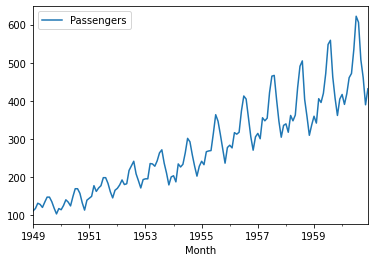

In [6]:
df.plot();

In [7]:
# set alpha for the EWMA below
alpha = 0.2

In [8]:
# calc exponentially weighted moving average
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [9]:
# check data type returned by ewm
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

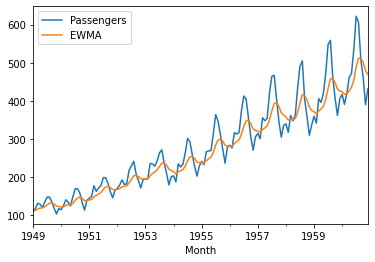

In [10]:
# plot again including our EWMA
df.plot();

In [11]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)
df['Manual'] = manual_ewma

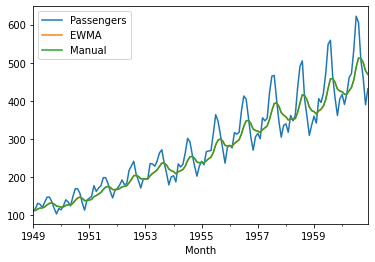

In [12]:
# plot again - this should match the above graph
df.plot();

In [13]:
# confirm manual method matches what we get using ewm in pandas
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [14]:
# drop manual from the df
df.drop('Manual', axis=1, inplace=True)

## Simple Exponential Smoothing

In [15]:
# import from statsmodels
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [16]:
# statsmodels expects univariate input
ses = SimpleExpSmoothing(df['Passengers'])

/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [17]:
# warning - we don't have a frequency assigned to our index
# what is our index?
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [18]:
# set the frequency to months (MS)
df.index.freq = 'MS'

In [19]:
# recreate ses now that we have frequency set
ses = SimpleExpSmoothing(df['Passengers'])

In [20]:
# call the fit function on our model - use same alpha from above
res = ses.fit(smoothing_level = alpha, optimized=False)

In [21]:
res

In [22]:
# get predictions for entire df
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [23]:
# add predictions to our df
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [24]:
# confirm the above predictions and fittedvalues are the same
np.allclose(df['SES'], res.fittedvalues)

True

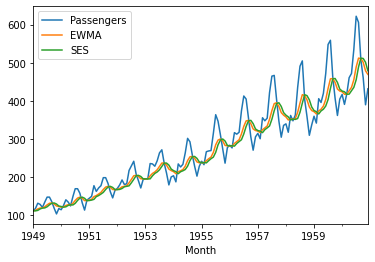

In [25]:
# note there is a small difference between SES and our pandas calculation
df.plot();

In [26]:
# SES is shifted by one
df.head(10)

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,113.200000,112.000000
1949-03-01,132,116.960000,113.200000
1949-04-01,129,119.368000,116.960000
1949-05-01,121,119.694400,119.368000
1949-06-01,135,122.755520,119.694400
1949-07-01,148,127.804416,122.755520
1949-08-01,148,131.843533,127.804416
1949-09-01,136,132.674826,131.843533


In [27]:
# shift SES back by one to confirm rest of the values
df['SES-1'] = df['SES'].shift(-1)

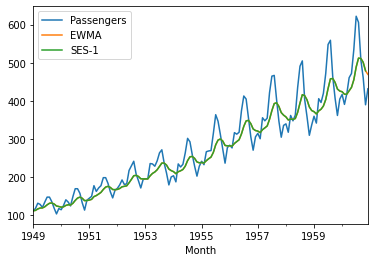

In [28]:
# replot and confirm that values line up
# note that this comes from the difference in forecasting
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [29]:
# treat this like a forecasting problem with a test set
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [30]:
# this will find the best alpha
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<ipython-input-31-702f581c7b53>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
<ipython-input-31-702f581c7b53>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)


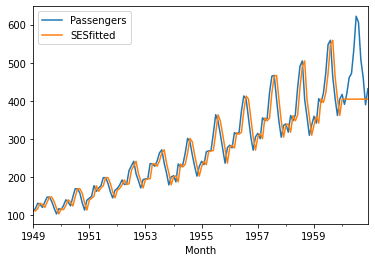

In [31]:
# add the results of our model back to our df
df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

The forecast is a horizontal line, as we expected for this simple model.

In [32]:
# what value was selected for alpha (smoothing_level)
# expect close to 1 since fitted tracks closely with actual
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Holt's Linear Trend Model

How to extend the forecast to more than a horizontal line.  The forecast equation is now equal to the level plus the linear trend.

In [33]:
# import
from statsmodels.tsa.holtwinters import Holt

In [34]:
holt = Holt(df['Passengers'])

/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [35]:
res_h = holt.fit()

In [36]:
df['Holt'] = res_h.fittedvalues

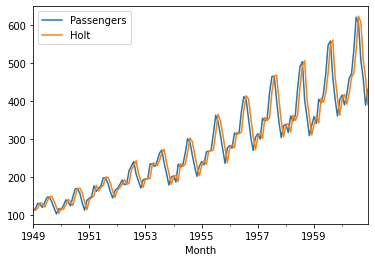

In [37]:
df[['Passengers', 'Holt']].plot();

Note that this still tracks the previous value

In [38]:
# use train/test split again for real forecast
holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[:-N_test, 'Holt'] = res_h.fittedvalues

/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-38-3fdbfa26188f>:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'Holt'] = res_h.fittedvalues


In [39]:
df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)

<ipython-input-39-e12628f9a209>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)


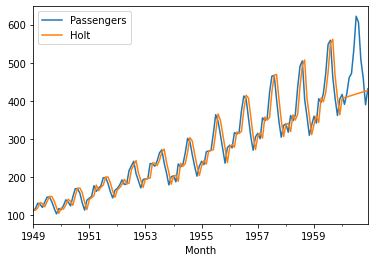

In [40]:
df[['Passengers', 'Holt']].plot();

Now instead of a horizontal line, our predictions include a linear trend.

## Holt-Winters

Extend the model with a seasonal component.

In [41]:
# import holt-winters model from statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [42]:
# fit model to training data
hw = ExponentialSmoothing(train['Passengers'], 
                          trend='add', 
                          seasonal='add', 
                          seasonal_periods=12)
res_hw = hw.fit()

/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [43]:
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)

<ipython-input-43-0c7c4410f2db>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
<ipython-input-43-0c7c4410f2db>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


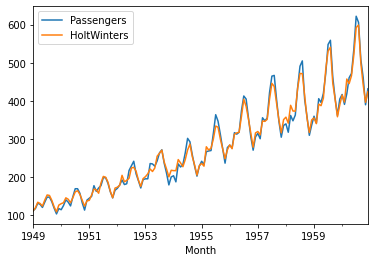

In [44]:
df[['Passengers', 'HoltWinters']].plot();

Note that this fits very well for the test set, and we don't have the timing issue anymore.

In [45]:
# calc metrics
def rmse(y, t):
    return np.sqrt(np.mean((y - t)**2))
def mae(y, t):
    return np.mean(np.abs(y - t))

In [46]:
print("Train RMSE: ", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE: ", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE:  11.624714430673352
Test RMSE:  16.978029847029934


In [47]:
print("Train MAE: ", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE: ", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE:  9.006650631052384
Test MAE:  13.37759090303536


/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-48-6769c5ce0d55>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
<ipython-input-48-6769c5ce0d55>:8: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


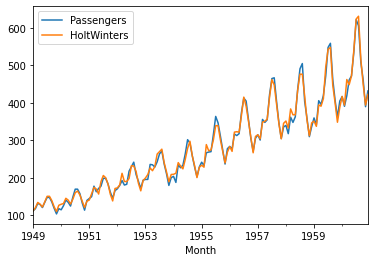

In [48]:
# try again with multiplicative seasonal model instead of additive
# amplitude seems to increase over time, so this may be better
hw = ExponentialSmoothing(train['Passengers'], 
                          trend='add', 
                          seasonal='mul', 
                          seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [49]:
print("Train RMSE: ", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE: ", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE:  9.767995205168011
Test RMSE:  15.810870232569963


In [50]:
print("Train MAE: ", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE: ", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE:  7.604272329965027
Test MAE:  10.30368288348438


/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/megan/projects/fineng/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
<ipython-input-51-de9c6a7e07f0>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
<ipython-input-51-de9c6a7e07f0>:8: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


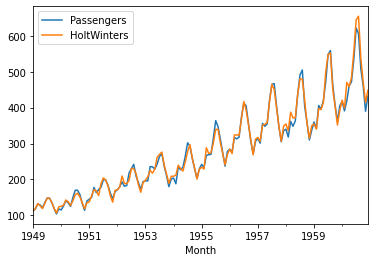

In [51]:
# try again with multiplicative for both
hw = ExponentialSmoothing(train['Passengers'], 
                          trend='mul', 
                          seasonal='mul', 
                          seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [52]:
print("Train RMSE: ", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE: ", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE:  9.61792487803932
Test RMSE:  25.80687515735493


In [53]:
print("Train MAE: ", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE: ", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE:  7.112379992634933
Test MAE:  20.844988412204554
